## Data Modeling
- Model Task is binary Classification
- Data Preprocessing
- Data Augmentation
    - Undersampling
    - SMOTE
- Data Split
    - Stratified 6:2:2
    - K-fold cv
- Modeling
    - Xgboost
    - Random forest
-Evaluation
    - precision, recall
    - marco-f1-score, accuracy
    - AU - PRC

### Data Class 나누기
- Fully Paid : 1497783
- Default(Charged Off + Default) : 362981

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os

In [4]:
data_path = "D:/archive (8)/Loan_status_2007-2020Q3.gzip"
data = pd.read_csv(data_path, low_memory=False)

In [5]:
#loan_data 특정 class만 살리고 Charged off -> Defalut class로 바꾸기기
data = data[data['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data['loan_status'].value_counts())

data['loan_status'] = data['loan_status'].replace("Charged Off", "Default")
print('\n',data['loan_status'].value_counts())

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [6]:
# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.

mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}


def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan


# Performing the encoding
data['loan_status'] = data['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

C:\Users\ksmin\AppData\Local\Temp\ipykernel_29492\3841752634.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


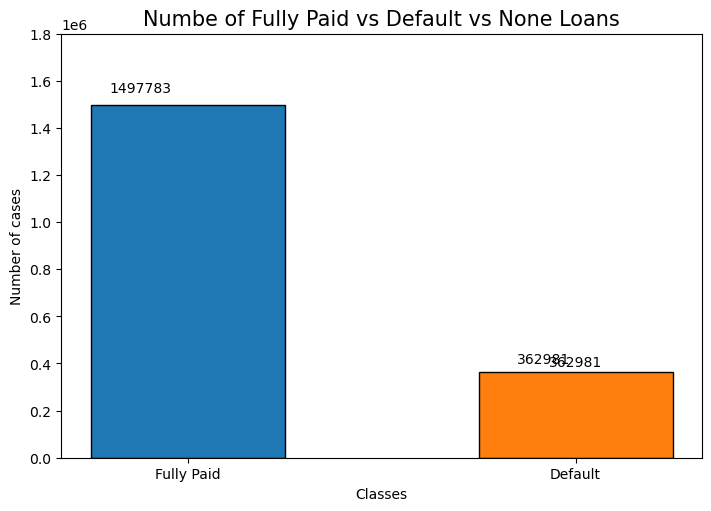

In [10]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [11]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of:    (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of:    (Fully Paid) / Default  : 4.126339946167981
